In [136]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
%matplotlib inline
# 한글폰트 사용
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)
import warnings
warnings.filterwarnings("ignore")

In [137]:
from fbprophet import Prophet
from datetime import datetime

## 한국거래소(krx)에서 종목코드 가져오기
KOSPI, KOSDAQ


In [178]:
# 엑셀파일 다운로드 링크를 pd.read_html을 이용해서 바로 읽어오는 메소드
df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13')[0]
df.head(3)


,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,DSR,155660,1차 비철금속 제조업,합섬섬유로프,2013-05-15,12월,홍석빈,http://www.dsr.com,부산광역시
1,GS글로벌,1250,상품 종합 도매업,"수출입업(시멘트,철강금속,전기전자,섬유,기계화학),상품중개,광업,채석업/하수처리 서...",1976-06-26,12월,김태형,http://www.gsgcorp.com,서울특별시
2,HDC현대산업개발,294870,건물 건설업,"외주주택, 자체공사, 일반건축, 토목 등",2018-06-12,12월,"권순호, 정경구",http://www.hdc-dvp.com,서울특별시


In [179]:
# Series 모든 원소에 작용하는 map함수 (DataFrame에서의 apply함수)

# 종목코드는 6자리이기 때문에 6자리를 맞춰주기
df.종목코드 = df.종목코드.map('{:06d}'.format)

df = df[['회사명','종목코드']]
df.rename(columns = {
    '회사명':'name',
    '종목코드':'code'
},inplace=True)
df.name = df.name.str.strip()
df.code = df.code.str.strip()
df.head(3)

,name,code
0,DSR,155660
1,GS글로벌,001250
2,HDC현대산업개발,294870


In [180]:
df.query("name=='DSR'")['code'].to_string(index=False).strip()

'155660'

## 네이버금융에서 종목 별 일자 데이터 가져오기
http://finance.naver.com/item/sise_day.nhn?code=종목코드 
에서 일자 데이터를 가져올 수 있다.<br>
이후에는 1페이지에서 20페이지까지의 데이터만 가져오기로 한다 <br>

In [181]:
""" 종목 이름을 입력하면 종목에 해당하는 코드를 불러와 
네이버 금융(http://finance.naver.com)에 넣어줌 """

def get_url(item_name, code_df): 
    # 종목이름, 종목이름/종목코드 데이터프레임
    code = code_df.query(f"name=='{item_name}'")['code'].to_string(index=False).strip() 
    # query 메소드: 조건에 맞는 데이터를 뽑을 때 사용
    # 괄호 안에 조건연산자를 사용한 조건 사용
    # 빈 스페이스가 하나 붙어 나오길래 strip()사용
    url = f'http://finance.naver.com/item/sise_day.nhn?code={code}'
    
    print(f"요청 URL : {url}") 
    return url

In [182]:
item_name = '삼성전자'
url = get_url(item_name, df)

요청 URL : http://finance.naver.com/item/sise_day.nhn?code=005930


In [183]:
# 가져오는 데이터를 append method를 사용해서 행(가로)으로 붙일 것
# 빈 데이터프레임 준비
tmp = pd.DataFrame()

In [184]:
# 1페이지에서 20페이지의 데이터만 가져오기 => 총 200일만 들어와야 함
for page in range(1, 21): 
    pg_url = f'{url}&page={page}'
    tmp = tmp.append(pd.read_html(pg_url, header=0)[0], ignore_index=True)

In [185]:
tmp = tmp.dropna()
tmp.날짜 = tmp.날짜.str.strip()
tmp.head(3)

,날짜,종가,전일비,시가,고가,저가,거래량
1,2020.12.07,72900.0,1400.0,72400.0,73500.0,71900.0,28197608.0
2,2020.12.04,71500.0,1800.0,70400.0,72100.0,70100.0,28130533.0
3,2020.12.03,69700.0,200.0,70100.0,70500.0,69300.0,23677989.0


In [186]:
type(tmp['날짜'][1])

str

In [187]:
# 시계열 타입으로 바꿔주기
from dateutil.parser import parse
tmp['날짜'] = tmp['날짜'].map(parse)

In [188]:
type(tmp['날짜'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [189]:
tmp.종가.dtype

dtype('float64')

In [190]:
GS = tmp[['날짜','종가']]

## naver, 카카오, LG 주식

In [221]:
stocks = ['NAVER','카카오','LG']
urls = []

In [222]:
for stock in stocks:
    urls.append(get_url(stock, df))
urls

요청 URL : http://finance.naver.com/item/sise_day.nhn?code=035420
요청 URL : http://finance.naver.com/item/sise_day.nhn?code=035720
요청 URL : http://finance.naver.com/item/sise_day.nhn?code=003550


['http://finance.naver.com/item/sise_day.nhn?code=035420',
 'http://finance.naver.com/item/sise_day.nhn?code=035720',
 'http://finance.naver.com/item/sise_day.nhn?code=003550']

In [193]:
df_list = []

# 1페이지에서 20페이지의 데이터만 가져오기 
""" 여기서 문제는 없어보임 """
for url in urls:
    for page in range(1, 21): 
        pg_url = f'{url}&page={page}'
        tmp = tmp.append(pd.read_html(pg_url, header=0)[0], ignore_index=True)
    df_list.append(tmp)

In [218]:
# 날짜가 두 번 들어오는 구간이 있어서 LG주식으로 확인 중
pg_url = f'{url}&page={7}'
pd.read_html(pg_url, header=0)[0]

,날짜,종가,전일비,시가,고가,저가,거래량
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020.09.08,79500.0,500.0,80000.0,80400.0,79200.0,230927.0
2,2020.09.07,80000.0,100.0,79800.0,80300.0,79200.0,205067.0
3,2020.09.04,80100.0,2900.0,80600.0,81400.0,79800.0,360976.0
4,2020.09.03,83000.0,300.0,83600.0,84100.0,82600.0,330537.0
5,2020.09.02,83300.0,600.0,83300.0,84700.0,82500.0,297160.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020.09.01,82700.0,0.0,82300.0,84300.0,82100.0,341958.0


##  # datetime 객체를 문자열로

In [195]:
# datetime.strftime(naver['날짜'].to_numpy()[10],'%Y-%m-%d')

## # 시,분,초 까지 나와있는 datetime객체에서 년,월,일까지만 가져오기

In [196]:
# naver['날짜'].to_numpy()[10].date()

## # 문자열을 datetime 객체로

In [197]:
# parse(naver['날짜'].to_numpy()[201]).date()

In [219]:
df_list

[                      날짜        종가     전일비        시가        고가        저가  \
 0    2020-12-07 00:00:00   72900.0  1400.0   72400.0   73500.0   71900.0   
 1    2020-12-04 00:00:00   71500.0  1800.0   70400.0   72100.0   70100.0   
 2    2020-12-03 00:00:00   69700.0   200.0   70100.0   70500.0   69300.0   
 3    2020-12-02 00:00:00   69500.0  1700.0   68400.0   69900.0   68300.0   
 4    2020-12-01 00:00:00   67800.0  1100.0   67100.0   68300.0   67100.0   
 ..                   ...       ...     ...       ...       ...       ...   
 495           2020.02.24  184000.0  5500.0  185500.0  187500.0  183500.0   
 496           2020.02.21  189500.0   500.0  187500.0  191000.0  187000.0   
 497           2020.02.20  190000.0   500.0  189500.0  191500.0  187500.0   
 498           2020.02.19  189500.0  3000.0  188000.0  191000.0  185000.0   
 499                  NaN       NaN     NaN       NaN       NaN       NaN   
 
             거래량  
 0    28197608.0  
 1    28130533.0  
 2    23677989.0 

In [198]:
naver = df_list[0].dropna()[['날짜','종가']]
""" try:
    naver['날짜'] = naver.apply(lambda r: parse(r['날짜']).date(), axis=1)
except:
    naver['날짜'] = naver.apply(lambda r: datetime.strftime(r['날짜'],'%Y-%m-%d'), axis=1) """

naver['날짜'] = naver.apply(lambda r: parse(r['날짜']).date() if type(r['날짜']) == str else r['날짜'].date() , axis=1)

naver

,날짜,종가
0,2020-12-07,72900.0
1,2020-12-04,71500.0
2,2020-12-03,69700.0
3,2020-12-02,69500.0
4,2020-12-01,67800.0
...,...,...
494,2020-02-25,190500.0
495,2020-02-24,184000.0
496,2020-02-21,189500.0
497,2020-02-20,190000.0


In [199]:
naver

,날짜,종가
0,2020-12-07,72900.0
1,2020-12-04,71500.0
2,2020-12-03,69700.0
3,2020-12-02,69500.0
4,2020-12-01,67800.0
...,...,...
494,2020-02-25,190500.0
495,2020-02-24,184000.0
496,2020-02-21,189500.0
497,2020-02-20,190000.0


In [200]:
kakao = df_list[1].dropna()[['날짜','종가']]
kakao['날짜'] = kakao.apply(lambda r: parse(r['날짜']).date() if type(r['날짜']) == str else r['날짜'].date() , axis=1)
kakao

,날짜,종가
0,2020-12-07,72900.0
1,2020-12-04,71500.0
2,2020-12-03,69700.0
3,2020-12-02,69500.0
4,2020-12-01,67800.0
...,...,...
794,2020-02-25,185500.0
795,2020-02-24,183500.0
796,2020-02-21,189500.0
797,2020-02-20,190500.0


In [201]:
LG = df_list[2].dropna()[['날짜','종가']]
LG['날짜'] = LG.apply(lambda r: parse(r['날짜']).date() if type(r['날짜']) == str else r['날짜'].date() , axis=1)
LG

,날짜,종가
0,2020-12-07,72900.0
1,2020-12-04,71500.0
2,2020-12-03,69700.0
3,2020-12-02,69500.0
4,2020-12-01,67800.0
...,...,...
1094,2020-02-25,71700.0
1095,2020-02-24,71700.0
1096,2020-02-21,74300.0
1097,2020-02-20,76000.0


# Prophet

In [202]:
future = model.make_future_dataframe(periods=60)

In [203]:
model = Prophet()

- model에 fit하기 위해서는 날짜 열의 이름을 ds로, 데이터 열의 이름을 y로 바꿔줘야 함

In [204]:
model.fit(naver)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [171]:
naver.rename(columns={'날짜':'ds','종가':'y'},inplace=True)
kakao.rename(columns={'날짜':'ds','종가':'y'},inplace=True)
LG.rename(columns={'날짜':'ds','종가':'y'},inplace=True)

In [172]:
model.fit(naver)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


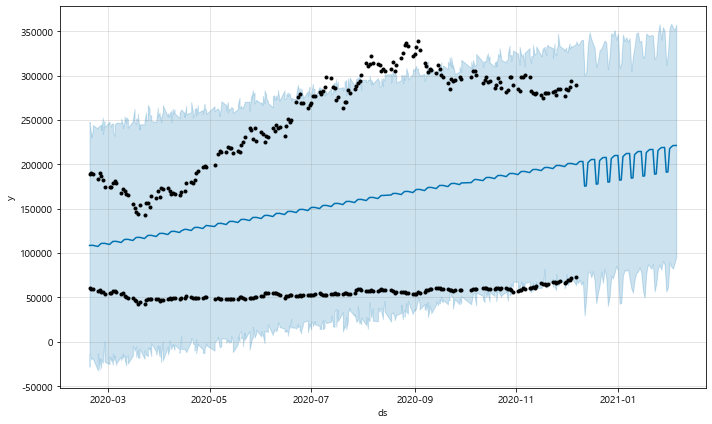

In [175]:
forecast = model.predict(future)
model.plot(forecast);

In [ ]:
model = Prophet(yearly_seasonality=True ,daily_seasonality=True)
# 모델 학습
model.fit(naver)

future = model.make_future_dataframe(periods=60)
future.tail(3)